In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import warnings
warnings.simplefilter('ignore')

import gc

from os import path
import sys
sys.path.append(path.abspath('..'))

In [40]:
import os
import cv2
import torch
import pandas as pd
from PIL import Image
from pprint import pprint
import albumentations as albu
from albumentations.pytorch import ToTensorV2

from src.lightning_module import PlanetModule

In [41]:
# DEVICE = 'cuda:0'
DEVICE = 'cpu'

In [42]:
# Загружаем модель

checkpoint_name = '../models/eff-b0_base_aug/epoch_epoch=11-val_f1=0.668.ckpt'
module = PlanetModule.load_from_checkpoint(checkpoint_name, map_location=torch.device('cpu'))


_ = module.eval()
_ = module.to(DEVICE)

In [43]:
DATA_FOLDER = '../data/'
!ls {DATA_FOLDER}

Images                df_valid.csv          test-jpg-additional
df_test.csv           sample_submission.csv train.csv
df_train.csv          test-jpg              train_classes.csv


In [44]:
# Загружаем данные
df = pd.read_csv(os.path.join(DATA_FOLDER, 'df_test.csv'))
names = list(df.columns[1:])
names
df.head()

['road',
 'cultivation',
 'agriculture',
 'haze',
 'clear',
 'habitation',
 'bare_ground',
 'blooming',
 'partly_cloudy',
 'selective_logging',
 'blow_down',
 'primary',
 'slash_burn',
 'artisinal_mine',
 'water',
 'conventional_mine',
 'cloudy']

,Id,road,cultivation,agriculture,haze,clear,habitation,bare_ground,blooming,partly_cloudy,selective_logging,blow_down,primary,slash_burn,artisinal_mine,water,conventional_mine,cloudy
0,train_3,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
1,train_5,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
2,train_9,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,train_12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,train_19,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [45]:
# препроцессинг данных 
img_height = 224
img_width = 224
preprocess = albu.Compose(
        [
            albu.Resize(height=img_height, width=img_width),
            albu.Normalize(),
            ToTensorV2(),
        ]
)

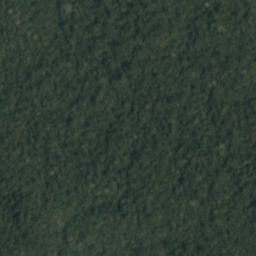

../data/Images/train_102.jpg


'train_102'

In [46]:
idx = 26
image_name = os.path.join(DATA_FOLDER, 'Images', f'{df["Id"][idx]}.jpg')
image = cv2.imread(image_name)[..., ::-1]
Image.fromarray(image)
print(image_name)
df["Id"][idx]


In [47]:
procecces_image = preprocess(image=image)['image']
with torch.no_grad():
    scores = torch.sigmoid(module(procecces_image[None].to(DEVICE)))[0].cpu().numpy()
    
rounded_scores = [round(s, 3) for s in scores]
pprint({n:[s,gt] for s, n, gt in zip(rounded_scores, names, df.iloc[idx][1:].values)})

{'agriculture': [0.0, 0],
 'artisinal_mine': [0.0, 0],
 'bare_ground': [0.0, 0],
 'blooming': [0.0, 0],
 'blow_down': [0.0, 0],
 'clear': [1.0, 1],
 'cloudy': [0.0, 0],
 'conventional_mine': [0.0, 0],
 'cultivation': [0.0, 0],
 'habitation': [0.0, 0],
 'haze': [0.0, 0],
 'partly_cloudy': [0.0, 0],
 'primary': [1.0, 1],
 'road': [0.0, 0],
 'selective_logging': [0.0, 0],
 'slash_burn': [0.0, 0],
 'water': [0.0, 0]}
